# Importing Packages and Settings

In [1]:
"""
Created on Tue Apr 11 21:36:26 2017

@author: shaffer
"""

# standard packages
import pandas as pd
from pandas_summary import DataFrameSummary # extra pandas function to summarize data statistics
import numpy as np
from IPython.display import display, HTML
import datetime as dt

# Protobuf compiled package
import RAPID_pb2 
SensorData = RAPID_pb2.SensorData()  # SensorData message
NodeData = RAPID_pb2.NodeData()      # NodeData message for Prof White's nodes

# network mapping package
import networkx as nx

# Plotting packages and notebook commands
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (15, 10)

# Ignore some warnings
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')

# Custom functions
from rapid_functions import log_to_df, log_to_df_server, range_mask, plot_network

# Jupyter notebook setting to automatically
# reload function file when a cell is run
%load_ext autoreload        
%autoreload 2

# Download Data to Dataframe

In [2]:
df = log_to_df_server(
    'http://winlink.from-il.com/2017-05-09T13:19:29.482600.log')
# pulls out most recent data for each node
df_latest = df.drop_duplicates(subset='nodeID',
                          take_last=True).reset_index(drop=True)

# Graph Network Configuration

Graphs the network configuration for each channel with data. Nodes are labeled with their nodeIDs. The data is also shown in a table for verification.

,IP,time_server,time_node,channel,rssi,nodeID,address,data,latency
0,152.228.51.53:37642,2017-05-08 19:59:22.046408,2017-05-08 19:59:21.996226162,97.0,NaN,13,1,080D250000C07F,0.050182
1,152.228.51.53:37900,2017-05-08 20:31:34.087921,2017-05-08 20:31:34.032564657,97.0,NaN,14,2,080E25142E9A422D00DEB8413521007744,0.055356
3,152.228.51.53:45978,2017-05-09 13:18:36.536840,2017-05-09 13:18:36.485159665,97.0,NaN,23,45,081715FFFC733F,0.051680
4,152.228.51.53:45980,2017-05-09 13:18:41.915204,2017-05-09 13:18:41.857454489,97.0,NaN,31,5,081F15534C9140,0.057750
5,152.228.51.53:45982,2017-05-09 13:18:46.320662,2017-05-09 13:18:46.263199822,97.0,NaN,21,3,0815155D749140,0.057462
7,152.228.51.53:45984,2017-05-09 13:19:28.664548,2017-05-09 13:19:28.609112912,97.0,NaN,1,445,080115B9E28A4025000090412D0000A041,0.055435


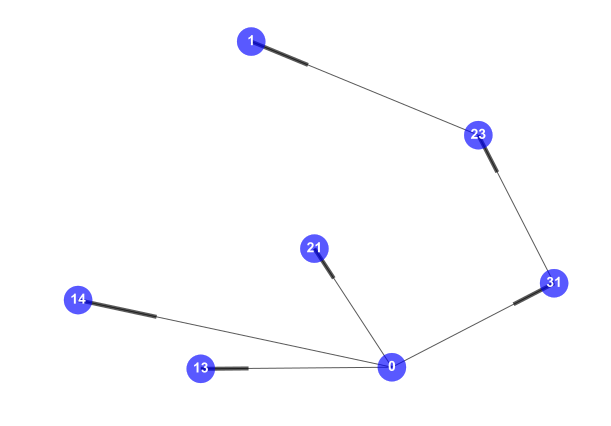

,IP,time_server,time_node,channel,rssi,nodeID,address,data,latency
2,152.228.54.203:37350,2017-05-09 12:14:19.088419,2017-05-09 12:14:19.028516863,60.0,NaN,15,4,080F2500808A41,0.059902
6,152.228.54.203:37508,2017-05-09 13:18:53.336596,2017-05-09 13:18:53.280734166,60.0,NaN,43,2,082B10E31618EDE3AAB902208F05,0.055862


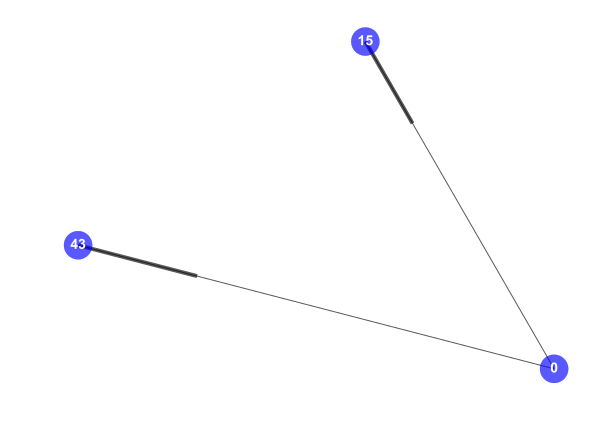

In [11]:
for channel in df_latest.channel.unique():
    display(df_latest[df_latest.channel==channel])
    G = plot_network(df_latest[df_latest.channel==channel])

# Graphing Latency

In [4]:
# determines if node communicates through relay
df['nodeType'] = df.address.astype(str).str.len()

The newly created ```nodeType``` column is determined based on the address assigned to each node.

| ```nodeType``` | Meaning          |
|----------------|------------------|
| 1              | Direct to Master |
| 2              | Through 1 Relay  |
| 3              | Through 2 Relays |

## Graph Latency with Outlier Included

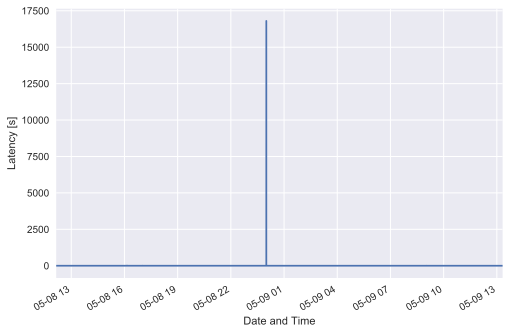

In [5]:
df_l = df.copy()            # create copy of dataframe
df_l.index = df_l.time_node # set index to datetime


# Ignore all latencies below 0
df_l.latency[df_l.latency<0] = np.nan
df_l.latency.plot();
plt.ylabel('Latency [s]');
plt.xlabel('Date and Time');
plt.show()

## Plotting after removing outlier

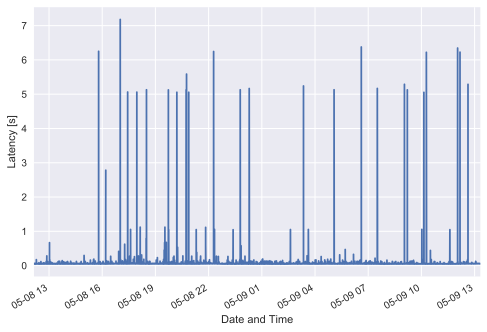

In [6]:
# Ignore all latencies above 1000
df_l.latency[df_l.latency>1000] = np.nan
df_l.latency.plot();
plt.ylabel('Latency [s]');
plt.xlabel('Date and Time');
plt.show()

## Plotting based on ```nodeType```

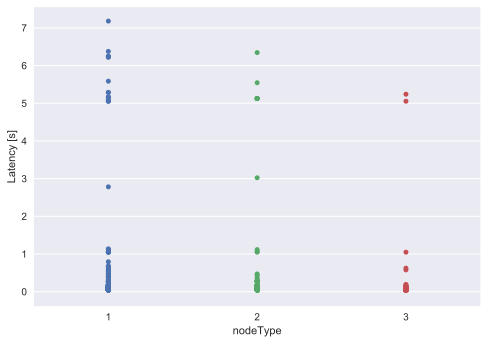

In [7]:
ax = sns.stripplot(x='nodeType', y='latency', data=df_l);
ax.set(ylabel='Latency [s]');
plt.show()

## Plotting based on ```nodeID```

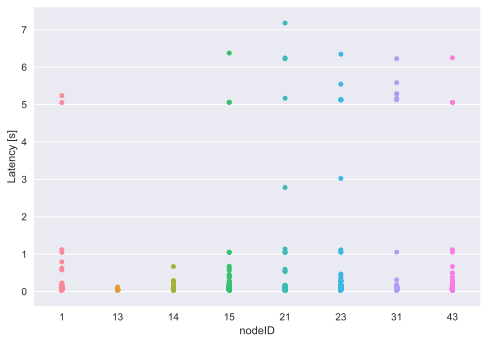

In [8]:
ax = sns.stripplot(x='nodeID', y='latency', data=df_l);
ax.set(ylabel='Latency [s]');
plt.show()

# Plotting Relay Node Voltage

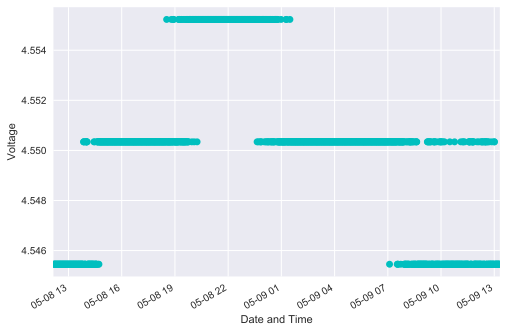

In [9]:
df21 = df[df.nodeID==21].copy() # pull out all node 21 data
df21.index = df21.time_node
df21['value'] = np.nan          # create empty column for data
for index in df21.index:
    # convert string hex data to bytes for protoc
    sensordata = bytes.fromhex(df21.data[index])
    serialized_data = SensorData.ParseFromString(sensordata)
    df21.loc[index,'voltage'] = SensorData.value
df21.voltage.plot(style='oc', alpha=.5);
plt.ylabel('Voltage');
plt.xlabel('Date and Time');
plt.show()